In [1]:
# import library
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.optimize import minimize
%matplotlib inline


In [2]:
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense

from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses
from sklearn.utils import shuffle


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11232277097895896293
]


In [3]:
data = pd.read_csv("temp_matrix (25).csv")
#check the data types
data.dtypes

timestamp        int64
date            object
time            object
day             object
irradiance     float64
temperature    float64
0              float64
1              float64
2              float64
3              float64
4              float64
5              float64
6              float64
7              float64
8              float64
9              float64
10             float64
11             float64
12             float64
13             float64
14             float64
15             float64
16             float64
17             float64
18             float64
19             float64
20             float64
21             float64
22             float64
23             float64
24             float64
25             float64
26             float64
27             float64
28             float64
29             float64
30             float64
31             float64
pmax           float64
SCC              int64
panel           object
dtype: object

In [4]:
#clean data:
clean = data[data.panel=='clean']

#seperating data into frames:

#These are columns that don't need to be normalized
clean1 = clean[['timestamp','date','time','day','panel']]

#everything else minus the timestamp column does need to be normalized
clean2 = clean.select_dtypes(include = ['float64','int64'])
clean2 = clean2.drop(columns=['timestamp'])
clean2

,irradiance,temperature,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,pmax,SCC
0,557.80,28.21,31.463,NaN,NaN,28.36625,NaN,30.656,29.605,NaN,...,NaN,26.068,25.936,NaN,26.624,NaN,NaN,25.9125,8801.920,673
2,787.00,33.99,45.556,NaN,NaN,46.98625,NaN,47.513,48.333,NaN,...,NaN,46.507,47.690,NaN,44.890,NaN,NaN,47.0325,56452.320,4520
4,916.77,32.31,49.921,NaN,NaN,52.91900,NaN,52.556,53.696,NaN,...,NaN,51.588,53.025,NaN,49.340,NaN,NaN,52.6700,61858.730,5299
6,1033.98,34.46,55.106,NaN,NaN,NaN,NaN,56.144,56.764,NaN,...,NaN,55.483,56.408,NaN,53.876,NaN,NaN,NaN,66282.240,5963
8,1030.84,35.25,55.494,NaN,NaN,55.81500,NaN,55.433,55.040,NaN,...,NaN,53.158,53.786,NaN,51.770,NaN,NaN,52.9100,67181.928,5990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3010,3.14,38.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43498.806,4026
3012,3.14,38.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32653.666,2777
3014,3.14,38.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9643.520,779
3016,3.14,38.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1429.268,224


In [5]:
#these columns are broken sensors, need to be replaced with 0's:
#01,02,04,07,12,15,16,19,24,27,29,30
clean2.update(clean2[['1','2','4','7','12','15','16','19','24','27','29','30']].fillna(0))
clean2.head()

,irradiance,temperature,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,pmax,SCC
0,557.80,28.21,31.463,0.0,0.0,28.36625,0.0,30.656,29.605,0.0,...,0.0,26.068,25.936,0.0,26.624,0.0,0.0,25.9125,8801.920,673
2,787.00,33.99,45.556,0.0,0.0,46.98625,0.0,47.513,48.333,0.0,...,0.0,46.507,47.690,0.0,44.890,0.0,0.0,47.0325,56452.320,4520
4,916.77,32.31,49.921,0.0,0.0,52.91900,0.0,52.556,53.696,0.0,...,0.0,51.588,53.025,0.0,49.340,0.0,0.0,52.6700,61858.730,5299
6,1033.98,34.46,55.106,0.0,0.0,NaN,0.0,56.144,56.764,0.0,...,0.0,55.483,56.408,0.0,53.876,0.0,0.0,NaN,66282.240,5963
8,1030.84,35.25,55.494,0.0,0.0,55.81500,0.0,55.433,55.040,0.0,...,0.0,53.158,53.786,0.0,51.770,0.0,0.0,52.9100,67181.928,5990


In [6]:
#replacing the remainder NaNs with meaningful values (not 0s)
#by default this will be a linear interpolation unless a different method is specified

new_clean2 = clean2.interpolate()
new_clean2

,irradiance,temperature,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,pmax,SCC
0,557.80,28.21,31.4630,0.0,0.0,28.36625,0.0,30.6560,29.6050,0.0,...,0.0,26.068,25.9360,0.0,26.624,0.0,0.0,25.9125,8801.920,673
2,787.00,33.99,45.5560,0.0,0.0,46.98625,0.0,47.5130,48.3330,0.0,...,0.0,46.507,47.6900,0.0,44.890,0.0,0.0,47.0325,56452.320,4520
4,916.77,32.31,49.9210,0.0,0.0,52.91900,0.0,52.5560,53.6960,0.0,...,0.0,51.588,53.0250,0.0,49.340,0.0,0.0,52.6700,61858.730,5299
6,1033.98,34.46,55.1060,0.0,0.0,54.36700,0.0,56.1440,56.7640,0.0,...,0.0,55.483,56.4080,0.0,53.876,0.0,0.0,52.7900,66282.240,5963
8,1030.84,35.25,55.4940,0.0,0.0,55.81500,0.0,55.4330,55.0400,0.0,...,0.0,53.158,53.7860,0.0,51.770,0.0,0.0,52.9100,67181.928,5990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3010,3.14,38.30,35.4225,0.0,0.0,35.53250,0.0,35.3775,35.3775,0.0,...,0.0,35.095,35.0775,0.0,35.190,0.0,0.0,34.9875,43498.806,4026
3012,3.14,38.30,35.4225,0.0,0.0,35.53250,0.0,35.3775,35.3775,0.0,...,0.0,35.095,35.0775,0.0,35.190,0.0,0.0,34.9875,32653.666,2777
3014,3.14,38.30,35.4225,0.0,0.0,35.53250,0.0,35.3775,35.3775,0.0,...,0.0,35.095,35.0775,0.0,35.190,0.0,0.0,34.9875,9643.520,779
3016,3.14,38.30,35.4225,0.0,0.0,35.53250,0.0,35.3775,35.3775,0.0,...,0.0,35.095,35.0775,0.0,35.190,0.0,0.0,34.9875,1429.268,224


In [7]:
#concatinating the dataframes:

clean_df = pd.concat([clean1, new_clean2], axis=1)

In [8]:
#seperating the newly revised data into frames for the independent & dependent variables
#the colon indicates all rows, and '00':'31' indicates all the columns from 00 to 31

clean_ind = clean_df.loc[:,'0':'31'] 
clean_dep = clean_df.loc[:,'pmax']

#reshaping the independent dataframe into 2D
clean_ind = clean_ind.to_numpy() #converting it to a numpy array
clean_ind[0].reshape(-1,4)


print(clean_ind.ndim)

#reshaping the dependent dataframes into 1D with the first value matching the first value of the 2D array
clean_dep = clean_dep.to_numpy() #converting it to a numpy array
clean_dep = clean_dep.reshape(-1,1)
print(clean_dep.ndim)

2
2


In [9]:
#Splitting the data into the Training and the Testing set
X_train,X_test,y_train,y_test,=train_test_split(clean_ind,clean_dep,test_size=0.2,random_state=0)

In [10]:
y_train[0]

array([64332.991])

In [11]:
X_train[0]

array([58.983     ,  0.        ,  0.        , 60.58333333,  0.        ,
       61.984     , 62.388     ,  0.        , 61.576     , 63.664     ,
       63.556     , 63.39666667,  0.        , 61.138     , 61.87      ,
        0.        ,  0.        , 59.533     , 59.745     ,  0.        ,
       59.469     , 60.145     , 60.751     , 61.88888889,  0.        ,
       61.108     , 62.119     ,  0.        , 59.107     ,  0.        ,
        0.        , 61.57777778])

In [12]:
#Feature scaleing using the fit transform function to calibrate the measurement so that the training and test data have a similar shape

#create MinMaxScaler objects
MinMaxScaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X_train = MinMaxScaler.fit_transform(X_train)
X_test = MinMaxScaler.fit_transform(X_test)

y_train = MinMaxScaler.fit_transform(y_train)
y_test = MinMaxScaler.fit_transform(y_test)

In [13]:
X_train = X_train.reshape(X_train.shape[0], 8,4,1)
X_train.ndim

4

In [14]:
X_test = X_test.reshape(X_test.shape[0], 8,4,1)
X_test.ndim

4

In [15]:
y_train.ndim

2

In [16]:
y_test.ndim

2

In [17]:
#Reserving 10000 samples for validation
X_val = X_train [-10000:]
y_val = y_train [-10000:]

In [18]:
#custome loss functions for r_square
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))

In [19]:
#EXAMPLE Learning Rate
epochs = 60
learning_rate = 0.1
decay_rate = learning_rate/epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)

In [20]:
#Learning Rate Model
lr_model = Sequential() 
# C1 Convolutional Layer
lr_model.add(Conv2D(6, kernel_size=(2, 2), strides=(1, 1), activation='relu', input_shape=(8,4,1), padding="same"))
    
# C3 Convolutional Layer
lr_model.add(Conv2D(16, kernel_size=(2, 2), strides=(1, 1), activation='relu', padding='valid'))

# C5 Fully Connected Convolutional Layer
lr_model.add(Conv2D(120, kernel_size=(2, 2), strides=(1, 1), activation='relu', padding='valid'))

#Flatten the CNN output so that we can connect it with fully connected layers
lr_model.add(Flatten())
    
#FC6 Fully Connected Layer
    #tune the number of units in the first Dense layer
lr_model.add(Dense(84, activation='relu'))

#Output Layer with softmax activation
lr_model.add(Dense(1, activation='relu'))
    
lr_model.compile(
    loss=r_square_loss, 
    optimizer=sgd, 
    metrics=['mse']
    )     

In [21]:
%%time
# Fit the model
batch_size = 10

# define the learning rate change 
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

# learning schedule callback
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate]

# invoke the LearningRateScheduler during the .fit() phase
lr_model_history = lr_model.fit(X_train, y_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                callbacks=callbacks_list,
                                verbose=1,
                                validation_data=(X_test, y_test))

Train on 1208 samples, validate on 302 samples
Epoch 1/60
1208/1208 [==============================] - 0s 301us/step - loss: 10.1213 - mse: 0.6416 - val_loss: 4.7347 - val_mse: 0.3405
Epoch 2/60
1208/1208 [==============================] - 0s 123us/step - loss: 4.9935 - mse: 0.3086 - val_loss: 4.7347 - val_mse: 0.3405
Epoch 3/60
1208/1208 [==============================] - 0s 124us/step - loss: 5.3717 - mse: 0.3086 - val_loss: 4.7347 - val_mse: 0.3405
Epoch 4/60
1208/1208 [==============================] - 0s 124us/step - loss: 5.0322 - mse: 0.3086 - val_loss: 4.7347 - val_mse: 0.3405
Epoch 5/60
1208/1208 [==============================] - 0s 128us/step - loss: 5.5121 - mse: 0.3086 - val_loss: 4.7347 - val_mse: 0.3405
Epoch 6/60
1208/1208 [==============================] - 0s 121us/step - loss: 5.4915 - mse: 0.3086 - val_loss: 4.7347 - val_mse: 0.3405
Epoch 7/60
1208/1208 [==============================] - 0s 123us/step - loss: 6.1747 - mse: 0.3086 - val_loss: 4.7347 - val_mse: 0.3405


1208/1208 [==============================] - 0s 126us/step - loss: 5.6335 - mse: 0.3086 - val_loss: 4.7347 - val_mse: 0.3405
Wall time: 9.67 s


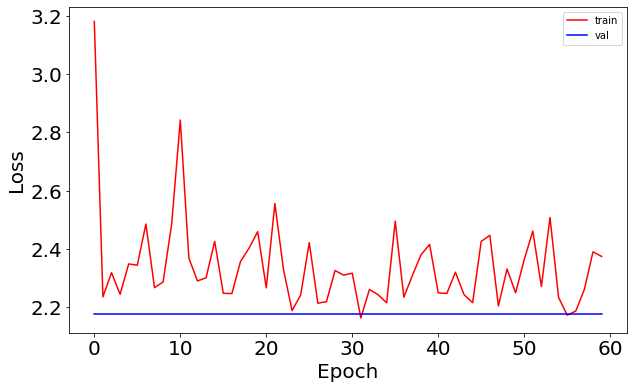

In [22]:
#Loss as a function of epochs
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

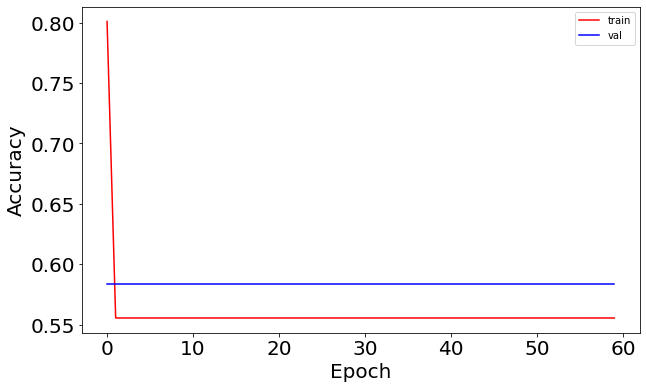

In [23]:
#accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['mse']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_mse']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [24]:
#evaluating the model on the rest data
test_score = lr_model.evaluate(X_test, y_test, batch_size=20)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

302/302 [==============================] - 0s 33us/step
Test loss 3.4856, accuracy 34.05%


In [25]:
#generate predications
print("Generate predictions for 3 samples:")
predictions = lr_model.predict(X_test[:3])
print("predictions shape:", predictions.shape)
lr_model.summary()

Generate predictions for 3 samples:
predictions shape: (3, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 8, 4, 6)           30        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 3, 16)          400       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 2, 120)         7800      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 84)                121044    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 85        
Total params: 129,359
Trainable params: 129,359
Non-traina